In [1]:
! pip install names-dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 MB 8.8 MB/s eta 0:00:00m eta 0:00:010:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 9.9 MB/s eta 0:00:000m eta 0:00:0136m0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for names-dataset: filename=names_dataset-3.1.0-py3-none-any.whl size=116832757 sha256=d418d7f77af194106681b3a661c59b00f3a02f8b4c47043c0d3c9be7cab351af
  Stored in directory: /home/hubert/.cache/pip/wheels/8b/36/2e/49513b778ca8d01a91a8cee61425d53de963b74561bfa5f561
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=e6e30ef7f0e3d1267af41b16508fdcf01b43c07577971226a18cee66fa534fb8
  Stored in directory: /home/hubert/.cache/pip/wheels/47/15/92/e6dc85fcb0686c82e1edbcfdf80cfe4808c058813fed0baa8f
Successfully built names-dataset pycountry


In [3]:
from names_dataset import NameDataset, NameWrapper
import numpy as np
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from typing import Tuple, List

In [4]:
class NamesDs(Dataset):
    def __init__(self, names: list, seq_len: int, lookup: dict = None) -> None:
        letters = sorted(list(set(''.join(names).lower())))
        self.seq_len = seq_len
        self.names = names
        self.start_token = 'bos'
        self.end_token = 'eos'
        self.padding_token = 'pad'
        self.lookup = lookup
        if lookup is None:
            self.lookup = {}
            for i in range(len(letters)):
                self.lookup[letters[i]] = i
            self.lookup[self.start_token] = len(letters)
            self.lookup[self.end_token] = len(letters) + 1
            self.lookup[self.padding_token] = len(letters) + 2
        
            self.idx2letter = self._idx2letter()
        
    
    def _idx2letter(self) -> dict:
        '''create lookup dictionary num --> char'''
        return {self.lookup[k]:k for k in self.lookup}
    
    def num_letters(self) -> int:
        '''dictionary lenght'''
        return len(self.lookup)
    
    def get_start_token(self) -> int:
        '''get numeric value of start token'''
        return self.lookup[self.start_token]
    
    def get_end_token(self) -> int:
        '''get numeric value of end token'''
        return self.lookup[self.end_token]
        
    def get_padding_token(self) -> int:
        '''get numeric value of padding token'''
        return self.lookup[self.padding_token]
    
    def __len__(self) -> int:
        '''num of samples in dataset'''
        return len(self.names)
    
    def idx2name(self, idx: torch.Tensor) -> str:
        '''transform index array to name'''
        ret = []
        for i in idx:
            if i == self.get_end_token():
                break
            elif i == self.get_start_token():
                continue
            ret.append(self.idx2letter[i.item()])
        return ''.join(ret)
    
    def name2idx(self, name: str) -> torch.Tensor:
        '''transform name to torch integer array'''
        chars = list(name)
        ret = [self.lookup[self.start_token]] + [self.lookup[c] for c in chars] + [self.lookup[self.end_token]]
        assert self.seq_len >= len(ret), 'sequnce length exceeds maximal sequence length'
        ret = ret + [self.lookup[self.padding_token]] * (self.seq_len - len(ret))  
        ret = torch.tensor(ret).long()
        return ret
        
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor]:
        '''prepare sample'''
        name = self.names[idx].lower()
        ret = self.name2idx(name)
        return ret  

In [5]:
A = torch.rand(2,3,4,4)
M = (torch.ones(4,4) * float("-inf")).triu(1)
A += M
A.softmax(dim=-1)

tensor([[[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.4493, 0.5507, 0.0000, 0.0000],
          [0.4294, 0.2305, 0.3401, 0.0000],
          [0.1410, 0.3236, 0.2069, 0.3286]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.6066, 0.3934, 0.0000, 0.0000],
          [0.3422, 0.3717, 0.2860, 0.0000],
          [0.2469, 0.2177, 0.2052, 0.3302]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.6029, 0.3971, 0.0000, 0.0000],
          [0.2547, 0.3413, 0.4040, 0.0000],
          [0.3362, 0.2024, 0.2270, 0.2344]]],


        [[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.6391, 0.3609, 0.0000, 0.0000],
          [0.3752, 0.3979, 0.2269, 0.0000],
          [0.2906, 0.3045, 0.1937, 0.2112]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.3904, 0.6096, 0.0000, 0.0000],
          [0.2909, 0.2828, 0.4263, 0.0000],
          [0.1585, 0.2693, 0.3085, 0.2638]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.3522, 0.6478, 0.0000, 0.0000],
          [0.2553, 0

In [6]:
class Config:
    '''config class containing arguments for transformers'''
    def __init__(self, **kwargs):
        self.d = 16
        self.input_dim = 16
        self.conditional = True
        self.n_heads = 4
        self.n_layers = 2
        self.dict_size = None
        self.out_dim = None
        self.max_seq_len = 50
        self._set_args(**kwargs)
    
    def _set_args(self, **kwargs):
        for key, value in kwargs.items():
            assert hasattr(self, key), f'Invalid argument: {key}'
            setattr(self, key, value)
        assert self.dict_size is not None, f'no value for dict_size provided! (dict_size has not default value)'

        
class SimpleSelfAttentionHead(nn.Module):
    '''Implementation of self attention head'''
    def __init__(self, config):
        super(SimpleSelfAttentionHead, self).__init__()
        
        self.d = config.d
        self.input_dim = config.input_dim
        self.beta = 1./np.sqrt(self.d)
        
        self.mapQ = nn.Parameter(torch.empty(self.input_dim, self.d).normal_()*0.02)
        self.mapK = nn.Parameter(torch.empty(self.input_dim, self.d).normal_()*0.02)
        self.mapV = nn.Parameter(torch.empty(self.input_dim, self.d).normal_()*0.02)
        
        self.use_mask = config.conditional
        self.mask = None
        
    def forward(self, X):
        Q = X @ self.mapQ
        K = X @ self.mapK
        V = X @ self.mapV
        
        A = Q @ K.permute(0,2,1) # keep batch size at first dimension
        A = A * self.beta
        if self.use_mask:
            seq_len = A.shape[-1]
            if self.mask is None or self.mask.shape[-1] != seq_len or self.mask.device != A.device:
                self.mask = (torch.ones(seq_len, seq_len) * float("-inf")).triu(1)
                self.mask = self.mask.to(X.device)
            A.data += self.mask
            
        A = A.softmax(dim=-1)
        
        V = A @ V
        return V
        
        
class SimmpleMultiheadAttention(nn.Module):
    '''Compose multiple self attention heads to multi attention head'''
    def __init__(self, config):
        super(SimmpleMultiheadAttention, self).__init__()
        
        self.n_heads = config.n_heads
        self.heads = nn.ModuleList([SimpleSelfAttentionHead(config) for _ in range(self.n_heads)])
        self.project = nn.Parameter(torch.empty( config.d * self.n_heads, config.input_dim).normal_()*0.02)
        self.act = torch.nn.GELU()
    
    def forward(self, X):
        heads = [ h(X) for h in self.heads]
        heads = torch.cat(heads, dim=-1)
        out = heads @ self.project
        out = self.act(out)
        return out
    
    
class AttentionLayer(nn.Module):
    '''Multi attention heads + linear layers and layer norms'''
    def __init__(self, config):
        super(AttentionLayer, self).__init__()
        
        self.feed_forward = nn.Linear(config.input_dim, config.input_dim)
        self.layernorm1 = nn.LayerNorm(config.input_dim)
        self.layernorm2 = nn.LayerNorm(config.input_dim)
        self.attention = SimmpleMultiheadAttention(config)
        
    def forward(self, X):
        out = self.attention(X)
        out = out + X
        out = self.layernorm1(out)
        out_f = self.feed_forward(out)
        out = out_f + out
        out = self.layernorm2(out)
        return out
        
        
class TransfomreEmbedding(nn.Module):
    '''word embedding + positional encoding'''
    def __init__(self, config):
        super(TransfomreEmbedding, self).__init__()
        self.embedding = nn.Embedding(config.dict_size, config.input_dim)
        # TODO!
        self.positional_encoding = nn.Parameter(torch.empty(config.max_seq_len, config.d).normal_()*0.02)
        
    def forward(self, idx):
        X = self.embedding(idx)
        X = X + self.positional_encoding
        return X

class SimpleTransformer(nn.Module):
    '''build the model but without output head'''
    def __init__(self, config):
        super(SimpleTransformer, self).__init__()
        self.dict_size = config.dict_size
        self.embedding = TransfomreEmbedding(config)
        self.n_layers = config.n_layers
        self.layers = nn.ModuleList([AttentionLayer(config) for _ in range(self.n_layers)])
    
    def forward(self, idx):
        X = self.embedding(idx)                                     
        for layer in self.layers:
            X = layer(X)
        return X
    
class ManyToManyHead(nn.Module):
    '''Output head for many to many task'''
    def __init__(self, config):
        super(ManyToManyHead, self).__init__()
        self.out_layer = nn.Linear(config.input_dim, config.out_dim)
        
    def forward(self, X):
        out = self.out_layer(X)
        return out

    
class ManyToManyTransformer(nn.Module):
    '''Combine base model and head to many to many model'''
    def __init__(self, config):
        super(ManyToManyTransformer, self).__init__()
        self.config = config
        self.simple_transformer = SimpleTransformer(config)
        self.out_head = ManyToManyHead(config)
    
    def forward(self, idx):
        out = self.simple_transformer(idx)
        out = self.out_head(out)
        return out
    
    def generate(self, bos_idx: int, eos_idx: int, pad_idx: int, start_idx: torch.Tensor=None, max_iter: int=10, from_top_k: int=1) -> List:
        # input/output idx
        #input_
        
        # in case of initial characters (see below) we need to check if "eos" token is already
        # in the sequence - in this case, we do not need any prediction
        has_finished = False 
        
        # if we have already some initial characters (i.e. the task is to complete a name
        seq = (torch.ones(self.config.max_seq_len) * pad_idx).long()
        start = None
        if start_idx is not None:
            seq[:len(start_idx)] = start_idx
            start = len(start_idx)
        else:
            # start sequence with "bos" token
            seq[0] = bos_idx
            start = 1
            
        # predict (rest of) the sequence
        for i in range(max_iter):
            out = self(seq[None])
            seq[start + i] = out[0,i].topk(from_top_k).indices[torch.rand(from_top_k).argmax()]
            if seq[start + i].item() == eos_idx:
                break
        
        return seq
        

In [7]:
def print_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))

In [8]:
config = Config(dict_size=10, out_dim=10, conditional=True)
model = ManyToManyTransformer(config)
print_model_size(model)

model size: 0.038MB


In [9]:
print_model_size(model.half())

model size: 0.019MB


In [11]:
def split_data(names, p_train):
    n_train = int(len(names) * p_train)
    # shuffle data
    idx = random.sample(range(len(names)), len(names))
    train_data = [names[i] for i in idx[:n_train]]
    val_data = [names[i] for i in idx[n_train:]]
    return train_data, val_data

In [12]:
# read names dataset and convert to lookup 
nd = NameDataset()
names = []
top_names = nd.get_top_names()
# use all first names of all countries
for i, countries in enumerate(top_names):
    print(f'\r reading names from country [{i+1}/{len(top_names)}]', end="")
    names += top_names[countries]['M']
    names += top_names[countries]['F']

 reading names from country [105/105]

In [11]:
#nd = NameDataset()
#names = nd.get_top_names(country_alpha2='AT')['AT']
#names = names['M'] + names['F']
# train_data[0]

In [13]:
def train(epoch, dataloader, model, loss_func, optimizer, scaler, device='cpu'):
    model.to(device)
    model.train()
    loss_ls = []
    n_samples = 0
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        bs = batch.shape[0]
        n_samples += bs
        model.zero_grad()
        
        with torch.cuda.amp.autocast():
            out = model(batch)
        
        # note: we need to compare the t'th output with the (t+1)'th token in our batch!
        # loss = loss_func(out[:,:-1].reshape(-1, model.config.dict_size), batch[:,1:].reshape(-1))
        loss = loss_func(out[:,:-1].reshape(-1, model.config.dict_size), batch[:,1:].reshape(-1))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    return loss.item()/bs 

In [14]:
def val(epoch, dataloader, model, loss_func, device='cpu'):
    model.to(device)
    model.eval()
    val_loss = []
    
    n_samples = 0
    loss_sum = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch = batch.to(device)
            out = model(batch)
            loss = loss_func(out[:,:-1].reshape(-1, model.config.dict_size), batch[:,1:].reshape(-1))
            #print(f'val loss: {loss}')
            loss_sum += loss.item()
            n_samples += batch.shape[0]
            #print(n_samples)
    avg_loss = loss_sum/n_samples
    return avg_loss                    

In [ ]:
def main(n_epochs=20):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    seq_len = 50

    # create split
    train_split, val_split = split_data(names, 0.75)

    # create datasets
    train_data = NamesDs(train_split, seq_len)
    val_data = NamesDs(val_split, seq_len)

    # create loader
    train_loader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=266, shuffle=False, num_workers=4)
    
    # create loss
    loss_fun = nn.CrossEntropyLoss(ignore_index=train_data.get_padding_token(), size_average=True)
    
    # instantiate model
    dict_size = train_data.num_letters()
    config = Config(dict_size=dict_size, 
                    out_dim=dict_size, 
                    d=128, 
                    input_dim=128, 
                    conditional=True)
    model = ManyToManyTransformer(config)
    
    # we use mixed precission
    scaler = torch.cuda.amp.GradScaler()
    
    # optimizer
    # optim = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    optim = torch.optim.AdamW(model.parameters(), lr=0.001)
    
    epochs = n_epochs
    
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        t_loss = train(epoch, train_loader, model, loss_fun, optim, scaler=scaler, device=device)
        v_loss = val(epoch, val_loader, model, loss_fun, device=device)
        print(f"\repoch: [{epoch}/{n_epochs}]: train_loss = {t_loss:.5f} | val_loss = {v_loss:.5f}", end="")
        train_loss.append(t_loss)
        val_loss.append(v_loss)
    return model, train_loss, val_loss, train_data, val_data

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
next(model.parameters()).is_cuda

True

In [53]:

model, train_loss, val_loss, train_data, val_data = main(n_epochs=50)

epoch: [2/50]: train_loss = 0.02061 | val_loss = 0.04851

IOStream.flush timed out
IOStream.flush timed out


epoch: [49/50]: train_loss = nan | val_loss = nan 0.05636

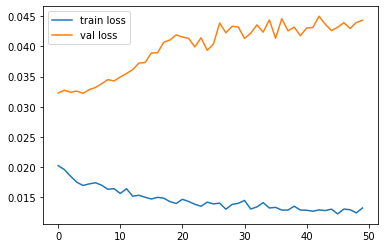

In [21]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()
plt.show()

In [41]:
model.to('cpu')
out = model.generate(bos_idx=train_data.get_start_token(),
                     eos_idx=train_data.get_end_token(),
                     pad_idx=train_data.get_padding_token(),
                     from_top_k=5)
train_data.idx2name(out)

'arnnishelapadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpad'

In [46]:
input_str = 'ju'
s = train_data.name2idx(input_str)[:len(input_str)+1]
print(len(s))
out = model.generate(bos_idx=train_data.get_start_token(), 
                     eos_idx=train_data.get_end_token(),
                     pad_idx=train_data.get_padding_token(),
                     start_idx=s, from_top_k=5)
train_data.idx2name(torch.tensor(out))

3


/tmp/ipykernel_11976/2442032038.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data.idx2name(torch.tensor(out))


'jumalildsayopadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpadpad'